Main question: Does a team being the manufacturer of their engine affect
performance (#wins, #points)?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from IPython.display import display

In [2]:
engine_manufacturers  = pd.read_csv('dataset/engine_manufacturers_processed.csv')
races                 = pd.read_csv('dataset/races.csv')
constructors          = pd.read_csv('dataset/constructors.csv')
constructor_standings = pd.read_csv('dataset/constructor_standings.csv')
engine_manufacturers  = pd.read_csv('dataset/engine_manufacturers_processed.csv')

In [3]:
# Before we get to the good stuff, we need to do a little data wrangling so we can see the results of 
# each constructor at the end of the year.
# Our data is separated like an SQL database, so we'll have to use a few joins/merges.

# We have engine manufacturer data between 2010-2020, so we need to filter races
# so they fall in the same timeframe.
races = races[(2010 <= races['year']) & (races['year'] <= 2020)]
races = races[['raceId', 'year', 'round']]   # Only need these 
# display(races[races['year'] == 2010])


In [4]:
# Note that there are some teams that changed their names in the 2010-2020 period, so we must account for that.
# Note that thte original dataset calls the team 'Alpha Tauri' 'AlphaTauri', so we need to account for that in the name change too.

def replace_constructor_by_name(df, original_names: list, new_name: str):
    df[df['name'].isin(original_names)] = df[df['name'] == new_name] 

def replace_constructor_by_id(df, original_names: list, new_name: str):
    df[df['constructorId'].isin(original_names)] = df[df['constructorId'] == new_name] 

replace_constructor_by_name(constructors, ['Force India'], 'Racing Point')
replace_constructor_by_name(constructors, ['Toro Rosso'], 'AlphaTauri')
replace_constructor_by_name(constructors, ['Sauber'], 'Alfa Romeo')
replace_constructor_by_name(constructors, ['Lotus', 'Lotus F1'], 'Renault')
replace_constructor_by_name(constructors, ['Virgin', 'Marussia'], 'Manor Marussia')

replace_constructor_by_id(constructor_standings, [10], 211)
replace_constructor_by_id(constructor_standings, [5], 213)
replace_constructor_by_id(constructor_standings, [15], 51)
replace_constructor_by_id(constructor_standings, [205, 208], 4)
replace_constructor_by_id(constructor_standings, [166, 206], 209)

In [5]:

constructor_standings_by_race = pd.merge(races, constructor_standings[['constructorId', 'raceId', 'points', 'wins']], on=['raceId'], how='left')
# display(constructor_standings_by_race[constructor_standings_by_race['raceId'] == 337])

constructor_standings_by_race = pd.merge(constructor_standings_by_race, engine_manufacturers, on=['year', 'constructorId'], how='left')
# display(constructor_standings_by_race[constructor_standings_by_race['raceId'] == 337])

constructor_standings_by_race = pd.merge(constructor_standings_by_race, constructors[['constructorId', 'name']], on=['constructorId'], how='left')

# This should display the raceId, year, constructorId, points,
# engine_manufacturer, name (of the team) for just one race in one year.
display(constructor_standings_by_race[constructor_standings_by_race['raceId'] == 337])

,raceId,year,round,constructorId,points,wins,Unnamed: 0,engine_manufacturer,name
0,337,2010,1,6.0,43.0,1.0,3,Ferrari,Ferrari
1,337,2010,1,1.0,21.0,0.0,0,Mercedes,McLaren
2,337,2010,1,9.0,16.0,0.0,2,Renault,Red Bull
3,337,2010,1,131.0,18.0,0.0,1,Mercedes,Mercedes
4,337,2010,1,3.0,1.0,0.0,4,Cosworth,Williams
5,337,2010,1,4.0,0.0,0.0,5,Renault,Renault
6,337,2010,1,4.0,0.0,0.0,8,Cosworth,Renault
7,337,2010,1,164.0,0.0,0.0,9,Cosworth,HRT


In [6]:
df = constructor_standings_by_race

# Since the results are accumualted, need to group by the constructor and year then subtract 
# each row from the preceeding one.
df['points'] = df.sort_values(['raceId', 'round']).groupby(['year', 'constructorId'])['points'].diff().fillna(0)
df['wins'] = df.sort_values(['raceId', 'round']).groupby(['year', 'constructorId'])['wins'].diff().fillna(0)

In [7]:
# Notice how 'Force India' becomes 'Racing Point' in the fifth row in 2010.
display(constructor_standings_by_race)

,raceId,year,round,constructorId,points,wins,Unnamed: 0,engine_manufacturer,name
0,337,2010,1,6.0,0.0,0.0,3,Ferrari,Ferrari
1,337,2010,1,1.0,0.0,0.0,0,Mercedes,McLaren
2,337,2010,1,9.0,0.0,0.0,2,Renault,Red Bull
3,337,2010,1,131.0,0.0,0.0,1,Mercedes,Mercedes
4,337,2010,1,3.0,0.0,0.0,4,Cosworth,Williams
...,...,...,...,...,...,...,...,...,...
1592,1047,2020,17,4.0,9.0,0.0,113,Renault,Renault
1593,1047,2020,17,51.0,0.0,0.0,116,Ferrari,Alfa Romeo
1594,1047,2020,17,3.0,0.0,0.0,118,Mercedes,Williams
1595,1047,2020,17,9.0,37.0,1.0,111,Honda,Red Bull


In [8]:
def linear_regression(df: pd.DataFrame, column: str):
    x = np.array(df['engine_manufacturer'])
    y = df[column]

    # Encode the categorical variable using OneHotEncoder
    encoder = OneHotEncoder()
    X_encoded = encoder.fit_transform(x.reshape(-1,1))

    # Fit a linear regression model to the data
    model = LinearRegression()
    model.fit(X_encoded, y)

    # Can also do `encoder.get_feature_names_out()` instead of the unique thing.
    print(f"Linear regression results for 'engine_manufacturer' vs '{column}'")
    print(pd.DataFrame({'Engine Manufacturer': np.unique(x), 'Coefficient': model.coef_}))

In [88]:
def logistic_regression(df: pd.DataFrame, col_name: str):
    # Create a binary feature indicating whether the team manufactures its own engine
    df['own_engine'] = (df['name'] == df['engine_manufacturer']).astype(int)
    column_mean = df[col_name].mean()

    # Select the relevant columns for the logistic regression model
    x = df[['own_engine']]
    y = (df[col_name] > column_mean).astype(int)

    # Fit a logistic regression model to the data
    model = LogisticRegression()
    model.fit(x, y)

    # Print the coefficients of the logistic regression model
    print('Logistic regression coefficients:', model.coef_)
    # print(model.intercept_)

Linear regression results for 'engine_manufacturer' vs 'points'
  Engine Manufacturer  Coefficient
0            Cosworth    -8.618574
1             Ferrari     2.247538
2               Honda    -0.960243
3            Mercedes     6.367299
4             Renault     0.963980
Linear regression results for 'engine_manufacturer' vs 'wins'
  Engine Manufacturer  Coefficient
0            Cosworth    -0.092395
1             Ferrari    -0.025009
2               Honda    -0.040221
3            Mercedes     0.141857
4             Renault     0.015768
Logistic regression coefficients: [[1.01509934]]
Logistic regression coefficients: [[0.9970607]]


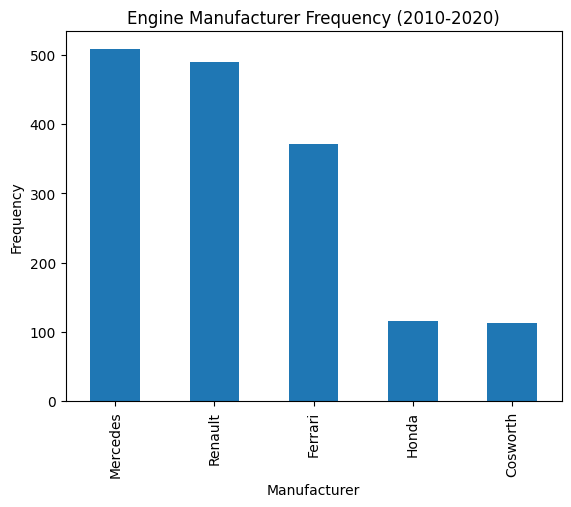

In [89]:
# Let's see how many times a manufacturer supplied to a team

ax = constructor_standings_by_race['engine_manufacturer'].value_counts().plot.bar()
ax.set_title('Engine Manufacturer Frequency (2010-2020)')
ax.set_xlabel('Manufacturer')
ax.set_ylabel('Frequency')


linear_regression(constructor_standings_by_race, 'points')
linear_regression(constructor_standings_by_race, 'wins')


logistic_regression(df, 'points')
logistic_regression(df, 'wins')

The magnitude and sign of each coefficient indicates that a team achieves more or
fewer points/wins on average relative to the others.  

##### Points
For example: for Mercedes, it's the team that achieves the most points on
average. While Cosworth usually scores the least points.

On average, the three engine manufacturers that supply their own teams engines
(Mercedes, Ferrari, and Renault) are the most likely to score more points as
indicated by the magnitudes and signs of their coefficients.
Notice that Ferrari is a bit negatively associated with wins, but not with points.

##### Wins
The same trend follows for wins.

In [27]:
# Sum the points and wins to get the total over a whole year.
grouped = constructor_standings_by_race.groupby(['year', 'name', 'engine_manufacturer']).sum(['wins', 'points'])
df: pd.DataFrame = grouped.reset_index()

In [28]:
# Now, let's filter out a list of all teams that manufacture their own engines (team name == engine manufacturer name).
matches: pd.Series = df.groupby('name').apply(lambda x: (x['name'] == x['engine_manufacturer']).sum())
display(matches)

# Only a few teams actually manufacture their own engines consistently, let's filter them out.
self_manufacturing_teams = list(matches[matches > 1].keys())

print(f"Teams that make their own engines: {self_manufacturing_teams}")

name
Alfa Romeo         0
AlphaTauri         0
Caterham           0
Ferrari           11
HRT                0
Haas F1 Team       0
Manor Marussia     0
McLaren            0
Mercedes          11
Racing Point       0
Red Bull           0
Renault            7
Williams           0
dtype: int64

Teams that make their own engines: ['Ferrari', 'Mercedes', 'Renault']


In [31]:
# WARNING: LONG OUTPUT
# for name in df['name'].unique():
#     display(df[df['name'] == name][['year', 'name', 'engine_manufacturer', 'wins', 'points']])

In [78]:
# Then we plot the points or wins of all teams, the ones making their own engines are solid, everyone else is dashed.
def plot_by_year(dataframe, y_axis_data_name, y_axis_plot_name, title):
    fig,ax = plt.subplots()
    fig.set_dpi(200)
    fig.set_size_inches(10, 5)

    for name in dataframe['name'].unique():
        ax.plot(
            dataframe[dataframe.name==name].year,
            dataframe[dataframe.name==name][y_axis_data_name],
            label=name, 
            linestyle='dashed' if name not in self_manufacturing_teams else 'solid'
        )

    ax.hlines(dataframe[y_axis_data_name].mean(), dataframe['year'].min(), dataframe['year'].max(), linestyles='dotted', label='Mean')

    ax.set_xlabel("Year")
    ax.set_ylabel(y_axis_plot_name)
    ax.legend(loc='best')
    plt.ylim((dataframe[y_axis_data_name].min() - 4, dataframe[y_axis_data_name].max() + 4))
    plt.title(title)
    plt.show()

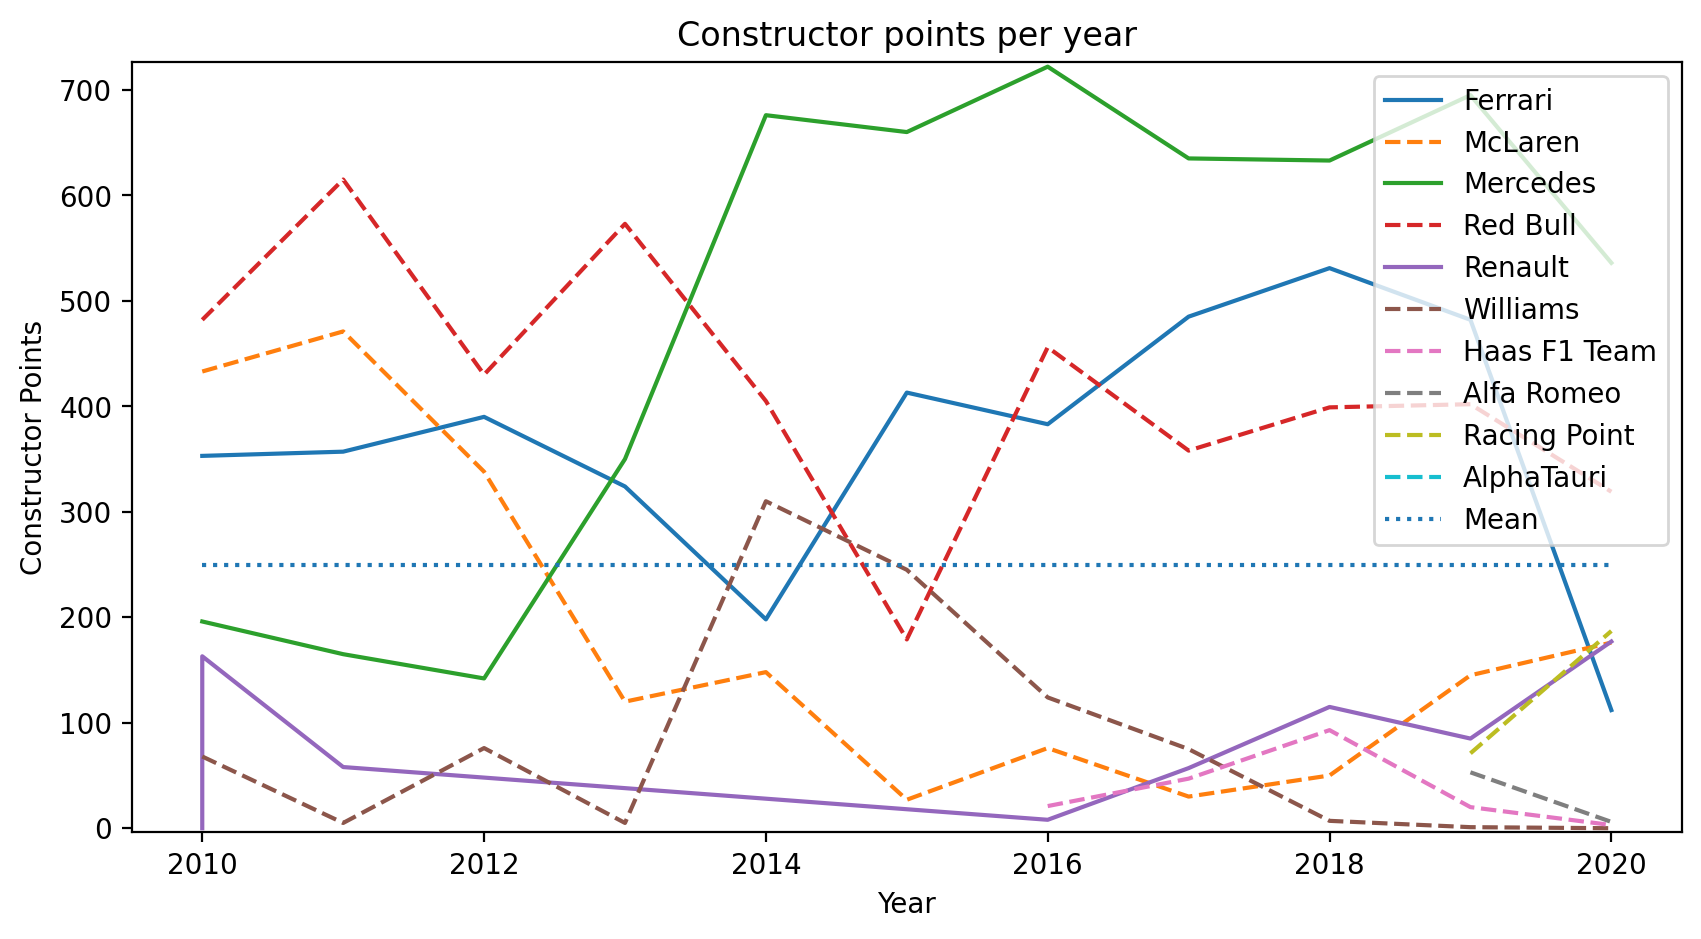

In [79]:
# Some teams can't be seen properly on the points graph due to their low scores.
# These teams are: HRT, Virgin, Caterham, Manor Marussiaa.
teams_to_drop = ['HRT', 'Virgin', 'Caterham', 'Manor Marussia']
points = df[~df['name'].isin(teams_to_drop)]


plot_by_year(points, 'points', 'Constructor Points', 'Constructor points per year')

In [80]:
display(points)

,year,name,engine_manufacturer,raceId,round,constructorId,points,wins,Unnamed: 0,own_engine
0,2010,Ferrari,Ferrari,6574,190,114.0,353.0,4.0,57,1
2,2010,McLaren,Mercedes,6574,190,19.0,433.0,5.0,0,0
3,2010,Mercedes,Mercedes,6574,190,2489.0,196.0,0.0,19,1
4,2010,Red Bull,Renault,6574,190,171.0,482.0,9.0,38,0
5,2010,Renault,Cosworth,6574,190,76.0,0.0,0.0,152,0
...,...,...,...,...,...,...,...,...,...,...
76,2020,Mercedes,Mercedes,17663,153,2227.0,536.0,12.0,1853,1
77,2020,Racing Point,Mercedes,17663,153,3587.0,187.0,1.0,1955,0
78,2020,Red Bull,Honda,17663,153,153.0,319.0,2.0,1887,0
79,2020,Renault,Renault,17663,153,68.0,177.0,0.0,1921,1


,year,name,engine_manufacturer,raceId,round,constructorId,points,wins,Unnamed: 0,own_engine
7,2010,Williams,Cosworth,6574,190,57.0,68.0,0.0,76,0
14,2011,Williams,Cosworth,16150,190,57.0,5.0,0.0,323,0
21,2012,Williams,Renault,17390,210,60.0,76.0,1.0,640,0
27,2013,Williams,Renault,16901,190,57.0,5.0,0.0,817,0
33,2014,Williams,Mercedes,17271,190,57.0,310.0,0.0,1045,0
39,2015,Williams,Mercedes,17775,190,57.0,245.0,0.0,1140,0
47,2016,Williams,Mercedes,20118,231,63.0,124.0,0.0,1470,0
54,2017,Williams,Mercedes,19570,210,60.0,75.0,0.0,1660,0
61,2018,Williams,Mercedes,20979,231,63.0,7.0,0.0,1953,0
70,2019,Williams,Mercedes,21420,231,63.0,1.0,0.0,2268,0


,year,name,engine_manufacturer,raceId,round,constructorId,points,wins,Unnamed: 0,own_engine
0,2010,Ferrari,Ferrari,6574,190,114.0,353.0,4.0,57,1
2,2010,McLaren,Mercedes,6574,190,19.0,433.0,5.0,0,0
4,2010,Red Bull,Renault,6574,190,171.0,482.0,9.0,38,0
8,2011,Ferrari,Ferrari,16150,190,114.0,357.0,1.0,266,1
10,2011,McLaren,Mercedes,16150,190,19.0,471.0,6.0,247,0
12,2011,Red Bull,Renault,16150,190,171.0,615.0,11.0,228,0
16,2012,Ferrari,Ferrari,17390,210,120.0,390.0,3.0,520,1
18,2012,McLaren,Mercedes,17390,210,20.0,338.0,6.0,500,0
19,2012,Mercedes,Mercedes,17390,210,2620.0,142.0,1.0,540,1
20,2012,Red Bull,Renault,17390,210,180.0,430.0,7.0,480,0


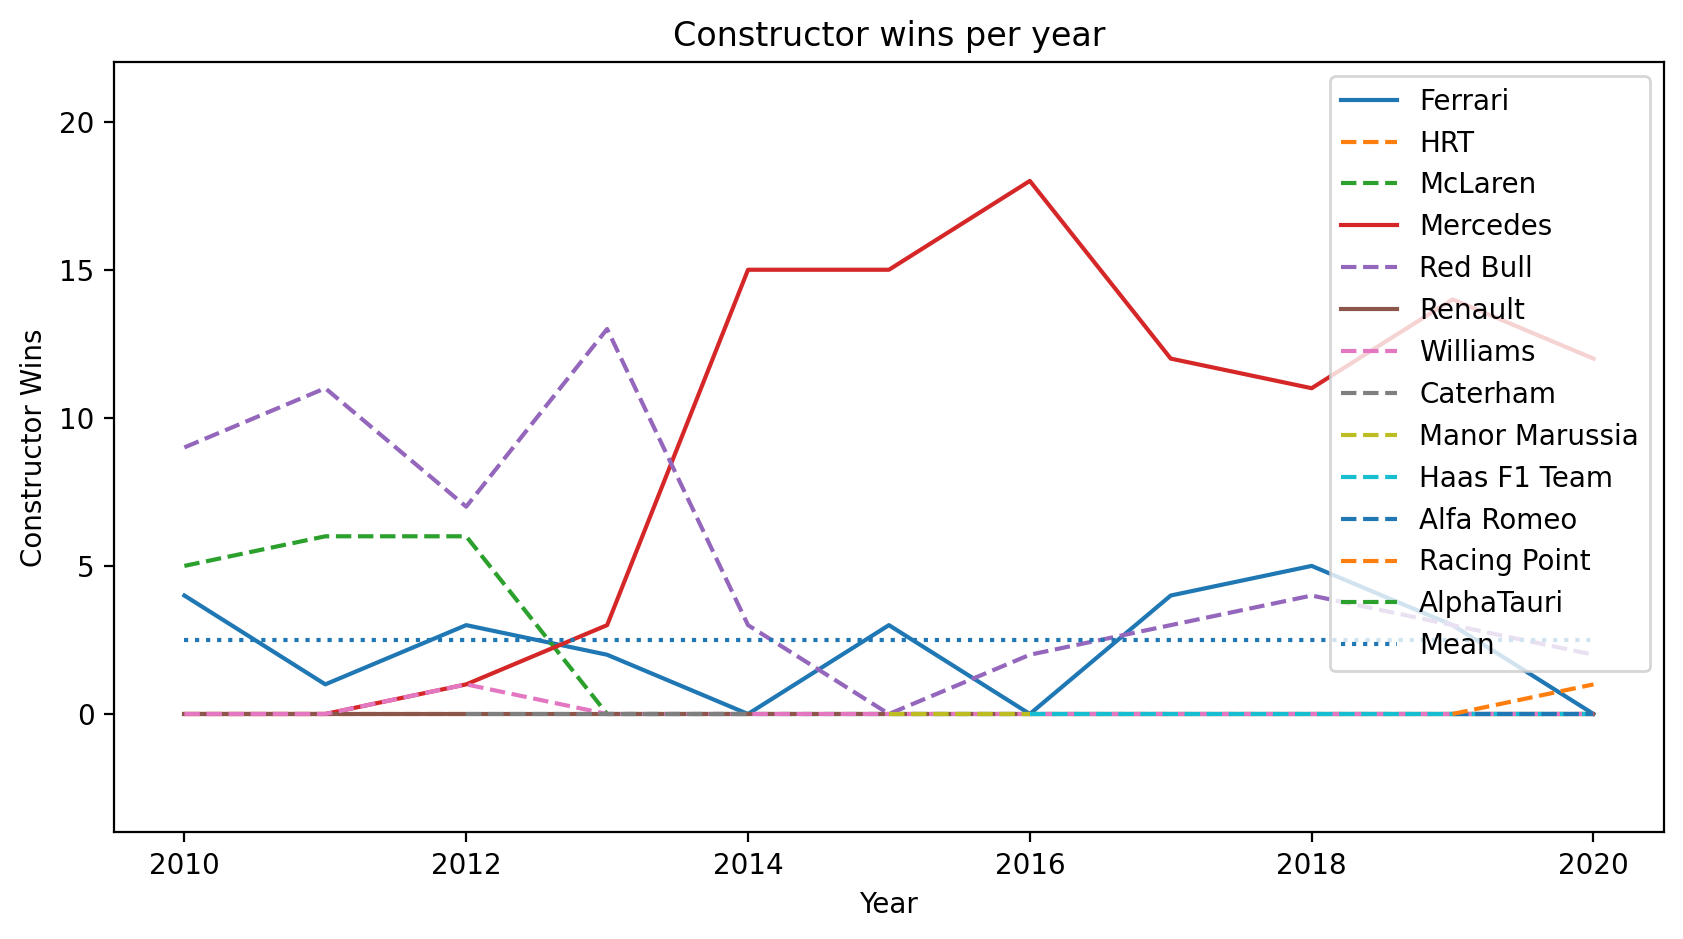

In [87]:
plot_by_year(df, 'wins', 'Constructor Wins', 'Constructor wins per year')

In [93]:
import scipy 

# H0: The mean points of teams that make their own engine is no different than
# the mean points of all teams.  
# H1: The mean points of teams that make their own engine is greater than ...

alpha = 0.05
engine_manufacturers_points = points[points['engine_manufacturer'] == points['name']]['points']
t_result = scipy.stats.ttest_1samp(engine_manufacturers_points, df['points'].mean(), alternative='greater')

if t_result.pvalue < alpha:
    print(f'One sample T-test p value ({t_result.pvalue}) < alpha ({alpha}). Null hypothesis rejected!')
else:
    print(f'One sample T-test p value ({t_result.pvalue}) > alpha ({alpha}). Failed to reject null hypothesis!')

One sample T-test p value (0.003013760179674353) < alpha (0.05). Null hypothesis rejected!


In [38]:
teams_to_drop = ['Alfa Romeo', 'AlphaTauri', 'Renault', 'Haas F1 Team', 'Williams', 'Racing Point', 'AlphaTauri', 'Manor Marussia', 'Caterham', 'HRT']
wins = df[~df['name'].isin(teams_to_drop)]

In [95]:
# H0: The mean wins of teams that make their own engine is no different than
# the mean wins of all teams.  
# H1: The mean wins of teams that make their own engine is greater than ...

alpha = 0.05
engine_manufacturers_wins = wins[wins['engine_manufacturer'] == wins['name']]['wins']
t_result = scipy.stats.ttest_1samp(engine_manufacturers_wins, df['wins'].mean(), alternative='greater')

if t_result.pvalue < alpha:
    print(f'One sample T-test p value ({t_result.pvalue}) < alpha ({alpha}). Null hypothesis rejected!')
else:
    print(f'One sample T-test p value ({t_result.pvalue}) > alpha ({alpha}). Failed to reject null hypothesis!')

One sample T-test p value (0.048461191999824765) < alpha (0.05). Null hypothesis rejected!
